In [1]:
import argparse
import pandas as pd
import numpy as np
import math
import h5py
from sklearn.model_selection import train_test_split
import joblib
import pickle
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import tensorflow as tf
import sys
import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import tensorflow.keras as keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Lambda, BatchNormalization, Activation, Concatenate, Dropout, Layer
from tensorflow.keras.layers import ReLU, LeakyReLU
from tensorflow.keras import backend as K
from tensorflow.keras import layers


from datetime import datetime
from tensorboard import program
import pathlib
import matplotlib as mpl
import matplotlib.pyplot as plt
import mplhep as hep
hep.style.use(hep.style.ROOT)
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=["#DB4437", "#4285F4", "#F4B400", "#0F9D58", "purple", "goldenrod", "peru", "coral","turquoise",'gray','navy','m','darkgreen','fuchsia','steelblue']) 
# from autoencoder_classes import AE,VAE

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TerminateOnNaN
from neptunecontrib.monitoring.keras import NeptuneMonitor
# from losses import mse_split_loss, radius, kl_loss
# from functions import make_mse_loss_numpy, save_model
from sklearn.metrics import roc_curve, auc


# from data_preprocessing import prepare_data
# from model import build_AE, build_VAE, build_QVAE


def return_total_loss(loss, bsm_t, bsm_pred):
    total_loss = loss(bsm_t, bsm_pred.astype(np.float32))
    return total_loss

import tensorflow_model_optimization as tfmot
tsk = tfmot.sparsity.keras

from qkeras.quantizers import quantized_bits

from keras.utils import tf_utils

quantize=False

In [2]:
input_hardqcd="/eos/uscms/store/group/lpctrig/jngadiub/L1TNtupleRun3-h5-extended-v2/QCD_preprocessed.h5"
input_qcd="/eos/uscms/store/group/lpctrig/jngadiub/L1TNtupleRun3-ZB-h5-extended-v2/ZB5_preprocessed.h5"
input_bsm = "/eos/uscms/store/group/lpctrig/jngadiub/L1TNtupleRun3-h5-extended-v2-120X/BSM_preprocessed.h5"
events=500000
norm = 'std'
output = {}


with h5py.File(input_qcd, 'r') as h5f:
    output['ZeroBias'] = {}
    
    data = np.array(h5f['full_data_cyl'][:events], dtype=np.float16)
    ET = np.array(h5f['ET'][:events], dtype=np.float16)
    L1bit = np.array(h5f['L1bit'][:events], dtype=np.int8)

    #mask saturated ET
    mask_ET = ET<2047.5
    ET = ET[mask_ET]
    data = data[mask_ET]
    L1bit = L1bit[mask_ET]
    
    #mask saturated PT
    mask_0  = data[:,0,0]<2047.5
    mask_1_9  = data[:,1:9,0]<255.5
    mask_9_20  = data[:,9:20,0]<1023.5
    mask = np.concatenate((mask_0[:,np.newaxis],mask_1_9,mask_9_20),axis=1)*1
    data = data*mask[:,:,np.newaxis]

    pt = np.copy(data[:,:,0])
    eta = np.copy(data[:,:,1])
    phi = np.copy(data[:,:,2])
    
    data[:,:,0] = pt*np.cos(phi)
    data[:,:,1] = pt*np.sin(phi)
    data[:,:,2] = pt*np.sinh(eta)
    data_target = np.copy(data)

    del pt, eta, phi, mask_ET, mask_0, mask_1_9, mask_9_20, mask

    if(norm=='ET'):
        data_target[:,:,:] = data[:,:,:]/ET[:,None,None]
        std_xy = (np.std(data_target[:,:,0])+np.std(data_target[:,:,1]))/2
        std_z = np.std(data_target[:,:,2])
        data_target[:,:,2] = data_target[:,:,2]*(std_xy/std_z)
    elif(norm=='std'):
        mean_qcd = np.mean(data_target, axis=0)
        std_qcd = np.std(data_target, axis=0)
        data_target = (data_target[:,:,:] - mean_qcd[None,:,:])/std_qcd[None,:,:]
        data_target[:,0,2] = 0
    else:
        data_target[:,0,:] = data[:,0,:]/2048
        data_target[:,1:9,:] = data[:,1:9,:]/256
        data_target[:,9:20,:] = data[:,9:20,:]/1024
        

    X_train, output['ZeroBias']['data'], Y_train, output['ZeroBias']['target'], _ , output['ZeroBias']['ET'], _ ,output['ZeroBias']['L1bit'] =  train_test_split( data, data_target, ET,L1bit, test_size=0.5)

    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1]*X_train.shape[2])
    Y_train = Y_train.reshape(Y_train.shape[0], Y_train.shape[1]*Y_train.shape[2])

del data, data_target, ET, L1bit


with h5py.File(input_hardqcd, 'r') as h5f:
    output['QCD'] = {}
    
    data = np.array(h5f['full_data_cyl'][:events], dtype=np.float16)
    ET = np.array(h5f['ET'][:events], dtype=np.float16)
    L1bit = np.array(h5f['L1bit'][:events], dtype=np.int8)

    #mask saturated ET
    mask_ET = ET<2047.5
    ET = ET[mask_ET]
    data = data[mask_ET]
    L1bit = L1bit[mask_ET]
    
    #mask saturated PT
    mask_0  = data[:,0,0]<2047.5
    mask_1_9  = data[:,1:9,0]<255.5
    mask_9_20  = data[:,9:20,0]<1023.5
    mask = np.concatenate((mask_0[:,np.newaxis],mask_1_9,mask_9_20),axis=1)*1
    data = data*mask[:,:,np.newaxis]

    pt = np.copy(data[:,:,0])
    eta = np.copy(data[:,:,1])
    phi = np.copy(data[:,:,2])
    
    data[:,:,0] = pt*np.cos(phi)
    data[:,:,1] = pt*np.sin(phi)
    data[:,:,2] = pt*np.sinh(eta)
    data_target = np.copy(data)

    del pt, eta, phi, mask_ET, mask_0, mask_1_9, mask_9_20, mask

    
    # print(h5f.keys())

    if(norm=='ET'):
        data_target[:,:,:] = data[:,:,:]/ET[:,None,None]
        data_target[:,:,2] = data_target[:,:,2]*(std_xy/std_z)
    elif(norm=='std'):

        data_target = (data_target[:,:,:] - mean_qcd[None,:,:])/std_qcd[None,:,:]
        # data_target[:,:,0] = (data_target[:,:,0]-mean_qcd[0])/std_qcd[0]
        # data_target[:,:,1] = (data_target[:,:,1]-mean_qcd[1])/std_qcd[1]
        # data_target[:,:,2] = (data_target[:,:,2]-mean_qcd[2])/std_qcd[2] 
        data_target[:,0,2] = 0
    else:
        data_target[:,0,:] = data[:,0,:]/2048
        data_target[:,1:9,:] = data[:,1:9,:]/256
        data_target[:,9:20,:] = data[:,9:20,:]/1024
        

    output['QCD']['data'], output['QCD']['target'], output['QCD']['ET'],output['QCD']['L1bit'] =   data, data_target, ET,L1bit

del data, data_target, ET, L1bit

with h5py.File(input_bsm,'r') as h5f2:
    for key in h5f2.keys():
        if('TT' not in key[:2]) and ('haa4b_ma15_powheg' not in key) and ('GluGluToHHTo4B_cHHH1' not in key): continue
        if len(h5f2[key].shape) < 3: continue
        print(key)
        output[str(key)] = {}
        output[str(key)]['data'] = np.array(h5f2[str(key)][:events,:,:],dtype=np.float16)
        output[str(key)]['ET'] = np.array(h5f2[str(key)+'_ET'][:events],dtype=np.float16)
        output[str(key)]['L1bit'] = np.array(h5f2[str(key)+'_l1bit'][:events],dtype=np.int8)

        #mask saturated ET
        mask_ET = output[str(key)]['ET']<2047.5
        output[str(key)]['ET'] = output[str(key)]['ET'][mask_ET]
        output[str(key)]['data'] = output[str(key)]['data'][mask_ET]
        output[str(key)]['L1bit'] = output[str(key)]['L1bit'][mask_ET]
        
        #mask saturated PT
        mask_0  = output[str(key)]['data'][:,0,0]<2047.5
        mask_1_9  = output[str(key)]['data'][:,1:9,0]<255.5
        mask_9_20  = output[str(key)]['data'][:,9:20,0]<1023.5
        mask = np.concatenate((mask_0[:,np.newaxis],mask_1_9,mask_9_20),axis=1)*1
        output[str(key)]['data'] = output[str(key)]['data']*mask[:,:,np.newaxis]

        pt = np.copy(output[str(key)]['data'][:,:,0])
        eta = np.copy(output[str(key)]['data'][:,:,1])
        phi = np.copy(output[str(key)]['data'][:,:,2])
        
        output[str(key)]['data'][:,:,0] = pt*np.cos(phi)
        output[str(key)]['data'][:,:,1] = pt*np.sin(phi)
        output[str(key)]['data'][:,:,2] = pt*np.sinh(eta)

        del pt, eta, phi, mask_ET, mask_0, mask_1_9, mask_9_20, mask


        output[str(key)]['target'] = np.copy(output[str(key)]['data'])
        if(norm=='ET'):
            output[str(key)]['target'] = output[str(key)]['data']/output[str(key)]['ET'][:,None,None]
            output[str(key)]['target'][:,:,2] = output[str(key)]['target'][:,:,2]*(std_xy/std_z)
        elif(norm=='std'):
            output[str(key)]['target'] = (output[str(key)]['target'] - mean_qcd[None,:,:])/std_qcd[None,:,:]
            # output[str(key)]['target'][:,:,0]= (output[str(key)]['data'][:,:,0]-mean_qcd[0])/std_qcd[0]
            # output[str(key)]['target'][:,:,1]= (output[str(key)]['data'][:,:,1]-mean_qcd[1])/std_qcd[1]
            # output[str(key)]['target'][:,:,2]= (output[str(key)]['data'][:,:,2]-mean_qcd[2])/std_qcd[2]
            output[str(key)]['target'][:,0,2] = 0
        elif(norm=='max_PT'):
            output[str(key)]['target'][:,0,:] = output[str(key)]['data'][:,0,:]/2048
            output[str(key)]['target'][:,1:9,:] = output[str(key)]['data'][:,1:9,:]/256
            output[str(key)]['target'][:,9:20,:] = output[str(key)]['data'][:,9:20,:]/1024

        

GluGluToHHTo4B_cHHH1
TT
haa4b_ma15_powheg


In [52]:
reco_scale = 1000
#beta = 0.8

def mse_loss(inputs, outputs):
    # remove last dimension
    inputs = tf.reshape(inputs, (tf.shape(inputs)[0],19,3))
    outputs = tf.reshape(outputs, (tf.shape(outputs)[0],19,3))
    
    mask0 = tf.math.not_equal(inputs[:,:,0],0)
    mask1 = tf.math.not_equal(inputs[:,:,1],0)
    mask2 = tf.math.not_equal(inputs[:,:,2],0)
    mask = tf.math.logical_and(mask0, mask1)
    mask = tf.math.logical_and(mask, mask2)
    # tf.print(mask)
    mask = tf.cast(mask, tf.float32)
    mask = tf.reshape(mask, (tf.shape(mask)[0],19,1))

    # remove zero entries
    loss = reco_scale*tf.reduce_mean(tf.square(inputs[:,:,:]-outputs[:,:,:])*mask)
    return loss

def mse_loss_numpy(inputs, outputs):
    # remove last dimension
    inputs = np.reshape(inputs, (inputs.shape[0],19,3))
    outputs = np.reshape(outputs, (outputs.shape[0],19,3))
    
    mask0 = inputs[:,:,0]!=0
    mask1 = inputs[:,:,1]!=0
    mask2 = inputs[:,:,2]!=0
    mask = (mask0 + mask1 + mask2)*1
    mask = np.reshape(mask, (mask.shape[0],19,1))
    inputs = inputs*mask
    outputs = outputs*mask

    # remove zero entries
    loss = np.mean(np.square(inputs.reshape(inputs.shape[0],57)-outputs.reshape(outputs.shape[0],57)),axis=1)
    return loss

def radius(mean, logvar):
    sigma = np.sqrt(np.exp(logvar))
    radius = mean*mean/sigma/sigma
    return np.sum(radius, axis=-1)

def kl_loss(mu, logvar, beta=None):
    kl_loss = 1 + logvar - np.square(mu) - np.exp(logvar)
    kl_loss = np.mean(kl_loss, axis=-1) # mean over latent dimensions
    kl_loss *= -0.5
    if beta!=None: return beta*kl_loss
    else: return kl_loss


class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

mse = tf.keras.losses.MeanSquaredError()

class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")
        self.total_val_loss_tracker = keras.metrics.Mean(name="total_val_loss")
        self.reconstruction_val_loss_tracker = keras.metrics.Mean(name="reconstruction_val_loss")
        self.kl_val_loss_tracker = keras.metrics.Mean(name="kl_val_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
            self.total_val_loss_tracker,
            self.reconstruction_val_loss_tracker,
            self.kl_val_loss_tracker,
        ]

    
    def train_step(self, data):
        data_in, target = data
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data_in)
            reconstruction = self.decoder(z)
            reconstruction_loss = (1-beta)*mse_loss(target, reconstruction) #one value
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = beta*tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        # tf.print(reconstruction_loss,kl_loss)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }
    
   
    def test_step(self, data):
        data_in, target = data
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data_in)
            reconstruction = self.decoder(z)
            reconstruction_loss = (1-beta)*mse_loss(target, reconstruction) #one value
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = beta*tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.total_val_loss_tracker.update_state(total_loss)
        self.reconstruction_val_loss_tracker.update_state(reconstruction_loss)
        self.kl_val_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_val_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_val_loss_tracker.result(),
            "kl_loss": self.kl_val_loss_tracker.result(),
        }
    
    
    def predict(self, data_in, batch_size=32, return_latent=False):
        # print(data_in)
        data_batch = tf.data.Dataset.from_tensor_slices((data_in))
        output, z_mean, z_logvar = [],[],[]
        for data in data_batch.batch(batch_size):
            # print(data.shape)
            z_mean_, z_logvar_, z_ = self.encoder(data)
            output_ = self.decoder(z_)
            output.append(output_)
            z_mean.append(z_mean_)
            z_logvar.append(z_logvar_)
        # print(len(output),len(z_mean),len(z_logvar))
        # print(output[0])
        output = tf.concat(output,0)
        z_mean = tf.concat(z_mean,0)
        z_logvar = tf.concat(z_logvar,0)
    
        if(return_latent):
            return tf_utils.sync_to_numpy_or_python_type(output), tf_utils.sync_to_numpy_or_python_type(z_mean), tf_utils.sync_to_numpy_or_python_type(z_logvar)
        else:
            return tf_utils.sync_to_numpy_or_python_type(output)
    


In [76]:
def main(hyperparameters):
    
    latent_dim = int(hyperparameters[:,0])
    outer_layer_width = int(hyperparameters[:,1])
    inner_layer_width = int(hyperparameters[:,2])
    beta = hyperparameters[:,3]
    #batch_size = int(hyperparameters[:,4])

    #latent_dim=4
    input_shape=57
    inputs = keras.Input(shape=(input_shape,))
    x = layers.Dense(outer_layer_width,kernel_initializer='lecun_uniform', activation='relu')(inputs)
    # x = layers.BatchNormalization()(x)
    x = layers.Dense(inner_layer_width,kernel_initializer='lecun_uniform', activation='relu')(x)
    # x = layers.BatchNormalization()(x)
    z_mean = layers.Dense(latent_dim,kernel_initializer='zeros')(x)
    z_logvar = layers.Dense(latent_dim,kernel_initializer='zeros')(x)
    z = Sampling()([z_mean, z_logvar])
    encoder = keras.Model(inputs, [z_mean, z_logvar, z], name="encoder")
    encoder.summary()


    latent_inputs = keras.Input(latent_dim,)
    y = layers.Dense(16,kernel_initializer='lecun_uniform', activation='relu')(latent_inputs)
    y = layers.Dense(32,kernel_initializer='lecun_uniform', activation='relu')(y)
    y = layers.Dense(64,kernel_initializer='lecun_uniform', activation='relu')(y)
    y = layers.Dense(128,kernel_initializer='lecun_uniform', activation='relu')(y)
    # y = layers.Dense(256,kernel_initializer='lecun_uniform', activation='relu')(y)
    decoded = layers.Dense(input_shape)(y)
    decoder = keras.Model(latent_inputs, decoded, name="decoder")
    decoder.summary()

    vae = VAE(encoder, decoder)
    vae.compile(optimizer=keras.optimizers.Adam())

    callbacks=[]
    callbacks.append(ReduceLROnPlateau(monitor='val_loss',  factor=0.1, patience=2, verbose=1, mode='auto', min_delta=0.1, cooldown=2, min_lr=1e-6))
    callbacks.append(TerminateOnNaN())
    # callbacks.append(NeptuneMonitor())
    callbacks.append(tf.keras.callbacks.EarlyStopping(monitor='val_loss',verbose=1, patience=2, restore_best_weights=True))
    
    history = vae.fit(Y_train, Y_train,validation_split=0.2, epochs=500, batch_size=512, verbose=1, callbacks=callbacks)
    
    
    for key in output.keys():
        output[key]['prediction'] = output[key]['prediction'][np.isfinite(output[key]['prediction'])]
        output[key]['reco_loss'] = output[key]['reco_loss'][np.isfinite(output[key]['reco_loss'])]
        output[key]['kl_loss'] = output[key]['kl_loss'][np.isfinite(output[key]['kl_loss'])]
        output[key]['radius'] = output[key]['radius'][np.isfinite(output[key]['radius'])]
        output[key]['total_loss'] = output[key]['total_loss'][np.isfinite(output[key]['total_loss'])]

    for key in output.keys():
        Y_predict, z_mean , z_logvar = vae.predict(output[key]['target'].reshape(output[key]['target'].shape[0],57),batch_size=1024*4,return_latent=True)
        Y_predict = Y_predict.reshape(Y_predict.shape[0],19,3)
        output[key]['prediction'] = Y_predict
        output[key]['reco_loss'] = mse_loss_numpy(output[key]['target'], Y_predict)
        output[key]['kl_loss'] = kl_loss(z_mean, z_logvar)
        output[key]['radius'] = radius(z_mean, z_logvar)
        output[key]['total_loss'] = output[key]['reco_loss'] + output[key]['kl_loss']
    
    # Evaluate the KL term
    qcd = output['ZeroBias']['target']
    bsm = output['TT']['target']

    kl_qcd = output['ZeroBias']['kl_loss']
    kl_bsm = output['TT']['kl_loss']

    kl_true_val = np.concatenate((np.ones(kl_bsm.shape[0]), np.zeros(kl_qcd.shape[0])))
    kl_pred_val = np.nan_to_num(np.concatenate((kl_bsm, kl_qcd)))

    kl_fpr_loss, kl_tpr_loss, kl_threshold_loss = roc_curve(kl_true_val, kl_pred_val)
    kl_objective = np.interp(10**(-5), kl_fpr_loss, kl_tpr_loss)

    # Evaluate the reco term (MSE)
    mse_qcd = output['ZeroBias']['reco_loss']
    mse_bsm = output['TT']['reco_loss']

    mse_true_val = np.concatenate((np.ones(bsm.shape[0]), np.zeros(qcd.shape[0])))
    mse_pred_val = np.concatenate((mse_bsm, mse_qcd))

    mse_fpr_loss, mse_tpr_loss, mse_threshold_loss = roc_curve(mse_true_val, mse_pred_val)
    mse_objective = np.interp(10**(-5), mse_fpr_loss, mse_tpr_loss)


    # The objective is the difference between the two
    objective = abs(mse_objective - kl_objective)
    
    return objective

In [80]:
%matplotlib inline  
import GPy
import GPyOpt
from numpy.random import seed

bounds = [{'name': 'latent_dim', 'type': 'discrete', 'domain':(3, 4, 5, 6, 7, 8)},
          {'name': 'outer_layer_width', 'type': 'discrete', 'domain':(16, 32, 64)},
          {'name': 'inner_layer_width', 'type': 'discrete', 'domain':(8, 16, 32)},
          {'name': 'beta', 'type': 'continuous', 'domain':(0,1)}]
          #{'name': 'batch_size', 'type': 'discrete', 'domain':(1024)}]

max_iter = 1000
myProblem = GPyOpt.methods.BayesianOptimization(main, domain=bounds)
myProblem.run_optimization(max_iter)

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_111 (InputLayer)         [(None, 57)]         0           []                               
                                                                                                  
 dense_490 (Dense)              (None, 16)           928         ['input_111[0][0]']              
                                                                                                  
 dense_491 (Dense)              (None, 16)           272         ['dense_490[0][0]']              
                                                                                                  
 dense_492 (Dense)              (None, 4)            68          ['dense_491[0][0]']              
                                                                                            

Epoch 1/500
391/391 [==============================] - 2s 4ms/step - loss: 186.7973 - reconstruction_loss: 191.4773 - kl_loss: 0.0485 - val_loss: 174.5067 - val_reconstruction_loss: 174.1967 - val_kl_loss: 0.3100 - lr: 0.0010
Epoch 2/500
391/391 [==============================] - 1s 3ms/step - loss: 179.4435 - reconstruction_loss: 186.6323 - kl_loss: 1.3830 - val_loss: 169.7820 - val_reconstruction_loss: 167.8947 - val_kl_loss: 1.8873 - lr: 0.0010
Epoch 3/500
391/391 [==============================] - 1s 4ms/step - loss: 174.7122 - reconstruction_loss: 182.3872 - kl_loss: 1.9760 - val_loss: 166.8794 - val_reconstruction_loss: 164.8303 - val_kl_loss: 2.0491 - lr: 0.0010
Epoch 4/500
391/391 [==============================] - 1s 4ms/step - loss: 169.5309 - reconstruction_loss: 178.2763 - kl_loss: 2.1830 - val_loss: 164.8335 - val_reconstruction_loss: 162.6871 - val_kl_loss: 2.1464 - lr: 0.0010
Epoch 5/500
391/391 [==============================] - 1s 3ms/step - loss: 175.1169 - reconstruc

Epoch 1/500
391/391 [==============================] - 2s 4ms/step - loss: 188.6876 - reconstruction_loss: 191.6487 - kl_loss: 0.0418 - val_loss: 174.8921 - val_reconstruction_loss: 174.8059 - val_kl_loss: 0.0862 - lr: 0.0010
Epoch 2/500
391/391 [==============================] - 1s 3ms/step - loss: 188.7884 - reconstruction_loss: 186.8481 - kl_loss: 1.3072 - val_loss: 170.5621 - val_reconstruction_loss: 168.7829 - val_kl_loss: 1.7793 - lr: 0.0010
Epoch 3/500
391/391 [==============================] - 1s 4ms/step - loss: 193.5890 - reconstruction_loss: 182.5260 - kl_loss: 2.0000 - val_loss: 166.8994 - val_reconstruction_loss: 164.8104 - val_kl_loss: 2.0890 - lr: 0.0010
Epoch 4/500
391/391 [==============================] - 1s 4ms/step - loss: 174.1148 - reconstruction_loss: 178.2277 - kl_loss: 2.2774 - val_loss: 163.9499 - val_reconstruction_loss: 161.6088 - val_kl_loss: 2.3411 - lr: 0.0010
Epoch 5/500
391/391 [==============================] - 1s 4ms/step - loss: 176.0700 - reconstruc

Epoch 1/500
391/391 [==============================] - 2s 5ms/step - loss: 201.4157 - reconstruction_loss: 191.3289 - kl_loss: 0.0902 - val_loss: 174.0612 - val_reconstruction_loss: 173.5919 - val_kl_loss: 0.4692 - lr: 0.0010
Epoch 2/500
391/391 [==============================] - 1s 4ms/step - loss: 241.2116 - reconstruction_loss: 187.5774 - kl_loss: 0.9614 - val_loss: 170.6261 - val_reconstruction_loss: 169.2584 - val_kl_loss: 1.3676 - lr: 0.0010
Epoch 3/500
391/391 [==============================] - 1s 3ms/step - loss: 182.7186 - reconstruction_loss: 181.8953 - kl_loss: 2.0059 - val_loss: 166.3161 - val_reconstruction_loss: 164.1633 - val_kl_loss: 2.1528 - lr: 0.0010
Epoch 4/500
391/391 [==============================] - 1s 4ms/step - loss: 176.9818 - reconstruction_loss: 178.9146 - kl_loss: 2.1895 - val_loss: 164.4079 - val_reconstruction_loss: 162.1434 - val_kl_loss: 2.2645 - lr: 0.0010
Epoch 5/500
391/391 [==============================] - 1s 4ms/step - loss: 208.2485 - reconstruc

Epoch 1/500
391/391 [==============================] - 2s 4ms/step - loss: 189.6095 - reconstruction_loss: 191.3563 - kl_loss: 0.0424 - val_loss: 174.6387 - val_reconstruction_loss: 174.3214 - val_kl_loss: 0.3172 - lr: 0.0010
Epoch 2/500
391/391 [==============================] - 1s 4ms/step - loss: 186.6011 - reconstruction_loss: 187.9889 - kl_loss: 0.9847 - val_loss: 171.3824 - val_reconstruction_loss: 169.7730 - val_kl_loss: 1.6095 - lr: 0.0010
Epoch 3/500
391/391 [==============================] - 1s 4ms/step - loss: 184.8987 - reconstruction_loss: 179.6813 - kl_loss: 2.6388 - val_loss: 165.2790 - val_reconstruction_loss: 162.3719 - val_kl_loss: 2.9071 - lr: 0.0010
Epoch 4/500
391/391 [==============================] - 1s 4ms/step - loss: 182.5050 - reconstruction_loss: 176.2797 - kl_loss: 3.2926 - val_loss: 163.0915 - val_reconstruction_loss: 160.0232 - val_kl_loss: 3.0683 - lr: 0.0010
Epoch 5/500
391/391 [==============================] - 1s 3ms/step - loss: 174.4514 - reconstruc

Epoch 16/500
391/391 [==============================] - 1s 3ms/step - loss: 153.2503 - reconstruction_loss: 145.8342 - kl_loss: 3.9488 - val_loss: 151.3137 - val_reconstruction_loss: 147.6548 - val_kl_loss: 3.6589 - lr: 0.0010
Epoch 17/500
378/391 [============================>.] - ETA: 0s - loss: 151.7008 - reconstruction_loss: 150.7594 - kl_loss: 3.9000
Epoch 00017: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Restoring model weights from the end of the best epoch: 15.
391/391 [==============================] - 1s 3ms/step - loss: 151.7989 - reconstruction_loss: 150.3763 - kl_loss: 3.9063 - val_loss: 150.2500 - val_reconstruction_loss: 146.5582 - val_kl_loss: 3.6918 - lr: 0.0010
Epoch 00017: early stopping
Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_129 (InputLayer)         [(None, 57)]

381/391 [============================>.] - ETA: 0s - loss: 154.6994 - reconstruction_loss: 154.5613 - kl_loss: 3.7220
Epoch 00012: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Restoring model weights from the end of the best epoch: 10.
391/391 [==============================] - 1s 3ms/step - loss: 154.7952 - reconstruction_loss: 154.3580 - kl_loss: 3.7179 - val_loss: 147.9372 - val_reconstruction_loss: 144.2745 - val_kl_loss: 3.6627 - lr: 0.0010
Epoch 00012: early stopping
Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_133 (InputLayer)         [(None, 57)]         0           []                               
                                                                                                  
 dense_589 (Dense)              (None, 64)           3712        ['input_133[0][0]']  

Epoch 55/500
391/391 [==============================] - 1s 4ms/step - loss: 133.8453 - reconstruction_loss: 131.0875 - kl_loss: 4.3235 - val_loss: 142.8288 - val_reconstruction_loss: 138.7346 - val_kl_loss: 4.0942 - lr: 1.0000e-05
Epoch 56/500
388/391 [============================>.] - ETA: 0s - loss: 136.7159 - reconstruction_loss: 131.1267 - kl_loss: 4.3305
Epoch 00056: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
391/391 [==============================] - 1s 3ms/step - loss: 136.7024 - reconstruction_loss: 131.0300 - kl_loss: 4.3268 - val_loss: 142.8035 - val_reconstruction_loss: 138.7057 - val_kl_loss: 4.0978 - lr: 1.0000e-05
Epoch 57/500
391/391 [==============================] - 1s 3ms/step - loss: 137.9811 - reconstruction_loss: 130.9750 - kl_loss: 4.3285 - val_loss: 142.7957 - val_reconstruction_loss: 138.6980 - val_kl_loss: 4.0978 - lr: 1.0000e-06
Epoch 58/500
391/391 [==============================] - 1s 3ms/step - loss: 136.5975 - reconstruction_loss: 

Epoch 15/500
391/391 [==============================] - 1s 3ms/step - loss: 153.2885 - reconstruction_loss: 152.6630 - kl_loss: 3.8576 - val_loss: 151.7577 - val_reconstruction_loss: 148.1931 - val_kl_loss: 3.5646 - lr: 0.0010
Epoch 16/500
391/391 [==============================] - 1s 4ms/step - loss: 156.0956 - reconstruction_loss: 149.2955 - kl_loss: 3.8165 - val_loss: 148.9469 - val_reconstruction_loss: 145.2867 - val_kl_loss: 3.6601 - lr: 0.0010
Epoch 17/500
391/391 [==============================] - 1s 4ms/step - loss: 147.1254 - reconstruction_loss: 146.9710 - kl_loss: 3.9082 - val_loss: 150.8207 - val_reconstruction_loss: 147.1062 - val_kl_loss: 3.7145 - lr: 0.0010
Epoch 18/500
375/391 [===========================>..] - ETA: 0s - loss: 153.1078 - reconstruction_loss: 145.5690 - kl_loss: 3.8451
Epoch 00018: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Restoring model weights from the end of the best epoch: 16.
391/391 [==============================] - 1s 3

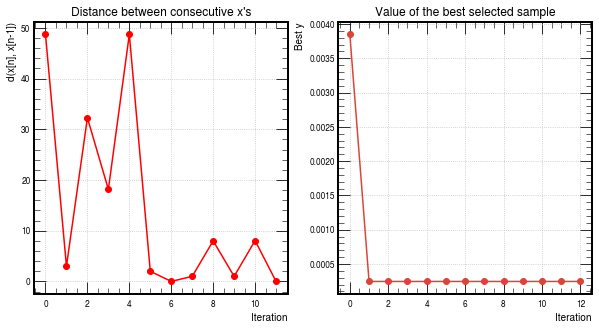

Writing evaluation results... 
    latent_dim  outer_layer_width  inner_layer_width          beta  objective
0          4.0               16.0               16.0  9.186001e-01   0.003849
1          6.0               64.0                8.0  1.631360e-01   0.000246
2          3.0               64.0                8.0  1.612322e-01   0.001230
3          7.0               32.0                8.0  1.292525e-01   0.019508
4          4.0               16.0               16.0  7.902077e-01   0.011854
5          6.0               64.0                8.0  1.635160e-01   0.011713
6          4.0               64.0                8.0  1.447487e-01   0.003471
7          4.0               64.0                8.0  1.561783e-01   0.001911
8          3.0               64.0                8.0  1.510058e-01   0.001932
9          3.0               64.0               16.0  0.000000e+00   0.002862
10         3.0               64.0               16.0  1.000000e+00   0.005901
11         3.0               64.0

In [84]:
# evaluate results of optimization
myProblem.plot_convergence()
print('Writing evaluation results... ')
param1 = myProblem.get_evaluations()[0][:,0].flatten()
param2 = myProblem.get_evaluations()[0][:,1].flatten()
param3 = myProblem.get_evaluations()[0][:,2].flatten()
param4 = myProblem.get_evaluations()[0][:,3].flatten()
#param5 = myProblem.get_evaluations()[0][:,4].flatten()
out = myProblem.get_evaluations()[1][:].flatten()
opt_results = {'latent_dim': param1,
               'outer_layer_width': param2,
               'inner_layer_width': param3,
               'beta': param4,
               #'batch_size': param5,
               'objective': out}

evals = pd.DataFrame(opt_results)
print(evals)

print('The value of (latent_dim, outer_layer width, inner_layer_width, beta) that minimizes the objective is: \n'+str(myProblem.x_opt))
print('The the max efficiency found is: '+str(myProblem.fx_opt))